































































































































































































































































































































































































































































































# Crude Oil Price Forecasting & Risk Analysis

**Author:** Daniel Edwards  
**Date:** 2025-09-26

**Objective:** Forecast WTI/Brent crude oil prices (short-term) and estimate market risk via Historical Simulation VaR.  
**Business Relevance:** Aligns with commercial trading, risk, and supply/scheduling at **Phillips 66** and **Shell (Trading & Supply)**.

## 0. Setup & Environment

In [1]:
# If running on a clean environment, uncomment the next cell and run it once.
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import json
from pathlib import Path
from dataclasses import dataclass
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
import yfinance as yf

ARTIFACTS = Path("artifacts")
ARTIFACTS.mkdir(exist_ok=True)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.rcParams["figure.figsize"] = (10, 5)

## 1. Data Acquisition

We provide two data sources:
1. **Yahoo Finance (default)** via `yfinance` — quick and reliable for WTI (`CL=F`) and Brent (`BZ=F`).
2. **EIA API (optional)** — if you have an API key, you can fetch benchmark series (e.g., WTI spot, Brent).

> Set `SYMBOL = "CL=F"` or `"BZ=F"` to choose the benchmark.

In [3]:
SYMBOL = "CL=F"   # 'CL=F' (WTI), 'BZ=F' (Brent). You can loop both later.
YEARS = 10
INTERVAL = "1d"

def get_prices_yahoo(symbol=SYMBOL, years=YEARS, interval=INTERVAL):
    df = yf.download(symbol, period=f"{years}y", interval=interval, auto_adjust=True, progress=False)
    df = df.rename(columns={"Close":"price"})
    df = df[["price"]].dropna()
    df.index = pd.to_datetime(df.index)
    return df

prices = get_prices_yahoo()
prices.head()

Price,price
Ticker,CL=F
Date,
2015-09-28,44.430000
2015-09-29,45.230000
2015-09-30,45.090000
2015-10-01,44.740002
2015-10-02,45.540001


## 2. Cleaning & Feature Engineering

In [4]:
df = prices.copy()
df = df.asfreq("B")  # business-day frequency
df["price"] = df["price"].interpolate(method="time")
df["ret"] = df["price"].pct_change()
df["logret"] = np.log1p(df["ret"])

# Rolling features
df["roll_mean_5"] = df["price"].rolling(5).mean()
df["roll_mean_20"] = df["price"].rolling(20).mean()
df["roll_vol_20"] = df["ret"].rolling(20).std() * np.sqrt(252)

df.tail()

Price,price,ret,logret,roll_mean_5,roll_mean_20,roll_vol_20
Ticker,CL=F,,,,,
Date,,,,,,
2025-09-22,62.639999,-0.000638,-0.000638,63.492000,63.524749,0.233586
2025-09-23,63.410000,0.012292,0.012218,63.270000,63.532749,0.222791
2025-09-24,64.989998,0.024917,0.024612,63.457999,63.574749,0.234621
2025-09-25,64.980003,-0.000154,-0.000154,63.740000,63.593750,0.233461
2025-09-26,64.849998,-0.002001,-0.002003,64.174000,63.635749,0.230959


## 3. Exploratory Data Analysis

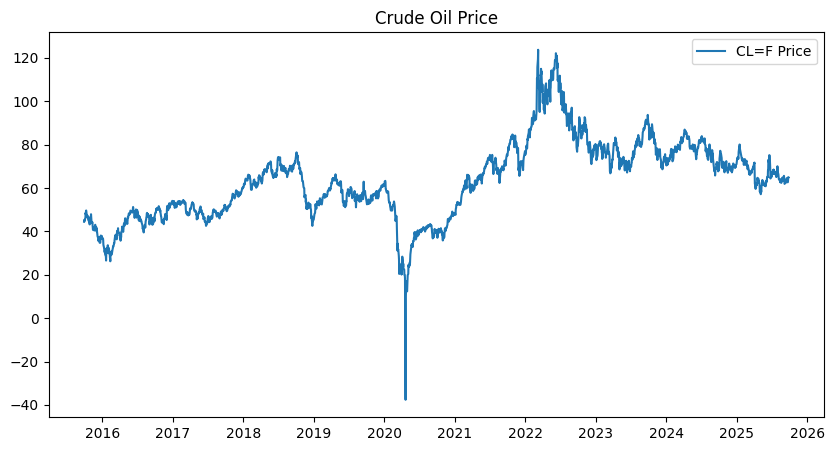

In [5]:
fig, ax = plt.subplots()
ax.plot(df.index, df["price"], label=f"{SYMBOL} Price")
ax.set_title("Crude Oil Price")
ax.legend()
plt.show()

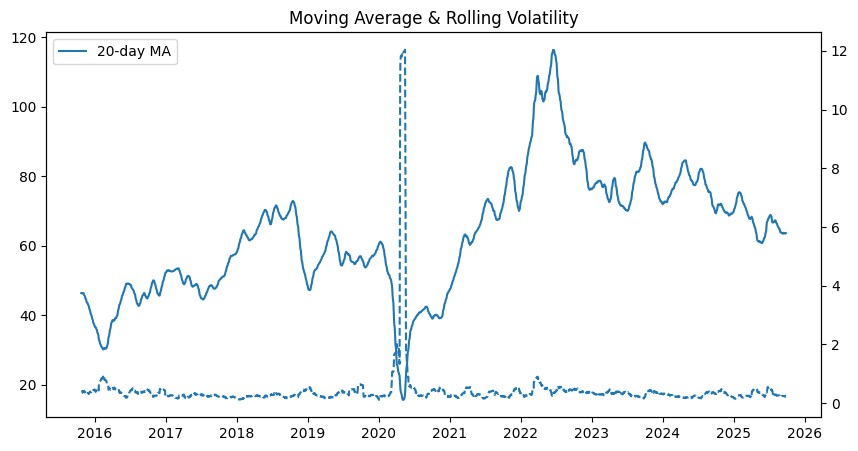

In [6]:
fig, ax = plt.subplots()
ax.plot(df.index, df["roll_mean_20"], label="20-day MA")
ax2 = ax.twinx()
ax2.plot(df.index, df["roll_vol_20"], label="Rolling Vol (20d)", linestyle="--")
ax.set_title("Moving Average & Rolling Volatility")
ax.legend(loc="upper left")
plt.show()

### Annotate Major Shocks
We'll annotate two key structural shocks:
- **COVID crash**: March–April 2020
- **Russia–Ukraine invasion**: from **2022-02-24**

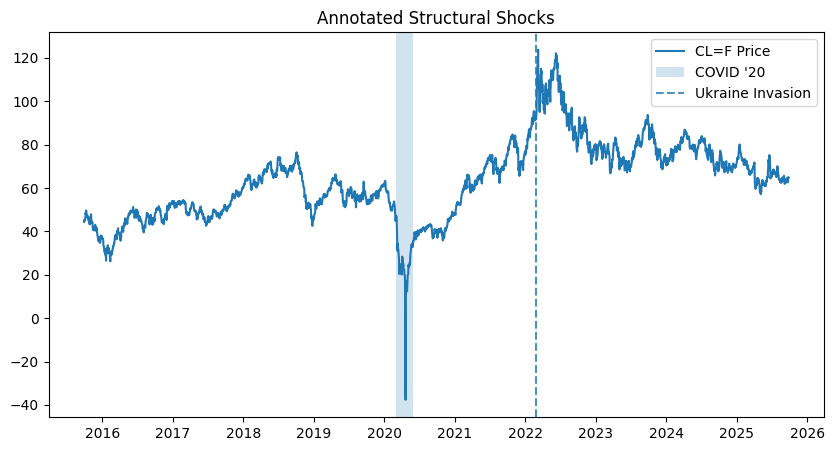

In [7]:
import datetime as dt

fig, ax = plt.subplots()
ax.plot(df.index, df["price"], label=f"{SYMBOL} Price")
ax.axvspan(pd.Timestamp("2020-03-01"), pd.Timestamp("2020-05-31"), alpha=0.2, label="COVID '20")
ax.axvline(pd.Timestamp("2022-02-24"), linestyle="--", alpha=0.8, label="Ukraine Invasion")
ax.set_title("Annotated Structural Shocks")
ax.legend()
plt.show()

## 4. Train / Test Split

In [8]:
HORIZON = 30  # forecast horizon (days)
test_start = df.index.max() - pd.tseries.offsets.BDay(HORIZON*2)  # keep 2x horizon for evaluation
train = df.loc[:test_start - pd.tseries.offsets.BDay(1)].copy()
test = df.loc[test_start:].copy()

y_train = train["price"].dropna()
y_test = test["price"].dropna()

train.tail(), test.head(), (train.index.min(), train.index.max(), test.index.min(), test.index.max())

(Price           price       ret    logret roll_mean_5 roll_mean_20 roll_vol_20
 Ticker           CL=F                                                         
 Date                                                                          
 2025-06-27  65.519997  0.004292  0.004283   65.712000     67.82225    0.542399
 2025-06-30  65.110001 -0.006258 -0.006277   65.031999     67.95175    0.535863
 2025-07-01  65.449997  0.005222  0.005208   65.247998     68.05375    0.534215
 2025-07-02  67.449997  0.030558  0.030100   65.753998     68.28375    0.541740
 2025-07-03  67.000000 -0.006672 -0.006694   66.105998     68.46525    0.542809,
 Price           price       ret    logret roll_mean_5 roll_mean_20 roll_vol_20
 Ticker           CL=F                                                         
 Date                                                                          
 2025-07-04  66.500000 -0.007463 -0.007491   66.301999    68.561250    0.540775
 2025-07-07  67.930000  0.021504  0.021

## 5. Baseline Models

In [9]:
def forecast_naive(train_series, horizon=HORIZON):
    last_val = float(train_series.iloc[-1])
    index = pd.bdate_range(start=train_series.index[-1] + pd.tseries.offsets.BDay(1), periods=horizon)
    return pd.Series([last_val]*horizon, index=index, name="naive")

def forecast_ma(train_series, horizon=HORIZON, window=5):
    last_ma = float(train_series.rolling(window).mean().iloc[-1])
    index = pd.bdate_range(start=train_series.index[-1] + pd.tseries.offsets.BDay(1), periods=horizon)
    return pd.Series([last_ma]*horizon, index=index, name="moving_avg")

fc_naive = forecast_naive(y_train)
fc_ma = forecast_ma(y_train, window=20)

fc_naive.head(), fc_ma.head()

(2025-07-04    67.0
 2025-07-07    67.0
 2025-07-08    67.0
 2025-07-09    67.0
 2025-07-10    67.0
 Freq: B, Name: naive, dtype: float64,
 2025-07-04    68.46525
 2025-07-07    68.46525
 2025-07-08    68.46525
 2025-07-09    68.46525
 2025-07-10    68.46525
 Freq: B, Name: moving_avg, dtype: float64)

## 6. Time-Series Model: SARIMAX (ARIMA)

In [10]:
# Simple parameter search over a small grid to keep runtime sane.
import itertools
p = d = q = [0, 1, 2]
params = list(itertools.product(p, d, q))
best_aic = np.inf
best_order = None
best_model = None

for order in params:
    try:
        model = sm.tsa.SARIMAX(y_train, order=order, enforce_stationarity=False, enforce_invertibility=False)
        res = model.fit(disp=False)
        if res.aic < best_aic:
            best_aic = res.aic
            best_order = order
            best_model = res
    except Exception:
        continue

print("Best ARIMA order:", best_order, "AIC:", best_aic)

# Forecast
pred = best_model.get_forecast(steps=HORIZON)
fc_arima = pd.Series(pred.predicted_mean.values,
                     index=pd.bdate_range(y_train.index[-1] + pd.tseries.offsets.BDay(1), periods=HORIZON),
                     name="arima")
conf_int = pred.conf_int(alpha=0.05)
arima_lower = pd.Series(conf_int.iloc[:,0].values, index=fc_arima.index, name="arima_lower")
arima_upper = pd.Series(conf_int.iloc[:,1].values, index=fc_arima.index, name="arima_upper")

/Users/dan/Documents/Documents - Daniel’s MacBook Pro/Projects/PersonalProjects/crude_forecast_var/.venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best ARIMA order: (1, 1, 2) AIC: 10930.737783810644


## 7. Prophet

In [11]:
try:
    from prophet import Prophet
    df_prophet = y_train.reset_index().rename(columns={"Date":"ds","price":"y"})
    df_prophet.columns = ["ds","y"]
    m = Prophet(changepoint_prior_scale=0.2, weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=True)
    m.fit(df_prophet)
    future = m.make_future_dataframe(periods=HORIZON, freq="B", include_history=False)
    forecast = m.predict(future)
    fc_prophet = forecast.set_index("ds")["yhat"].rename("prophet")
    prophet_bounds = forecast.set_index("ds")[["yhat_lower","yhat_upper"]]
except Exception as e:
    print("Prophet not available or failed:", e)
    fc_prophet = None
    prophet_bounds = None

12:18:24 - cmdstanpy - INFO - Chain [1] start processing
12:18:24 - cmdstanpy - INFO - Chain [1] done processing


## 8. ML with Lagged Features: Random Forest

In [12]:
# --- 8. ML with Lagged Features: Random Forest (robust & fast on macOS) ---

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# Rebuild df safely in case cells ran out of order
df = prices.copy().asfreq("B")
df["price"] = df["price"].interpolate(method="time")
df["ret"] = df["price"].pct_change()

def make_supervised(prices, lags=(1,2,5,10,20), rolls=(5,20)):
    """Coerce to 1-D Series, build lag & rolling features, drop NaNs."""
    # ensure 1-D Series
    if isinstance(prices, pd.DataFrame):
        s = prices.squeeze("columns")
    elif isinstance(prices, np.ndarray):
        s = pd.Series(np.ravel(prices), index=getattr(prices, "index", None))
    elif isinstance(prices, pd.Series):
        s = prices.copy()
    else:
        s = pd.Series(prices, index=df.index)
    s = pd.Series(np.ravel(np.asarray(s)), index=s.index, name="y")

    # features
    dfX = pd.concat({"y": s}, axis=1)
    for L in lags:
        dfX[f"lag_{L}"] = s.shift(L)
    for R in rolls:
        dfX[f"roll_mean_{R}"] = s.rolling(R).mean()
        dfX[f"roll_std_{R}"]  = s.rolling(R).std()
    dfX["dow"] = dfX.index.dayofweek

    dfX = dfX.dropna()
    y = dfX["y"].copy()
    X = dfX.drop(columns=["y"]).copy()
    return X, y

# Build features/targets
X, y = make_supervised(df["price"])

# Align with existing split defined earlier (train/test & y_test)
X_train, y_train_rf = X.loc[:train.index.max()], y.loc[:train.index.max()]
X_test,  y_test_rf  = X.loc[test.index.min():],  y.loc[test.index.min():]

# Safety: drop any lingering NaNs and downcast to float32 (speed)
mask = X_train.notna().all(axis=1) & y_train_rf.notna()
X_train = X_train[mask].astype("float32")
y_train_rf = y_train_rf[mask]

X_test = X_test.astype("float32")

# macOS-friendly settings: fewer threads, controlled depth
rf = RandomForestRegressor(
    n_estimators=150,   # start light; you can raise to ~300 once it works
    max_depth=12,      # prevents huge trees that slow/hang
    min_samples_leaf=3,
    random_state=42,
    n_jobs=1           # CRUCIAL on macOS; try 1 or 2, avoid -1
)

print("Fitting RandomForest...")
rf.fit(X_train, y_train_rf)
print("Done.")

# Make a horizon-length forecast aligned to y_test
forecast_index = y_test.index[:HORIZON]
rf_pred = pd.Series(rf.predict(X_test.loc[forecast_index]),
                    index=forecast_index, name="rf")
rf_pred.head()


Fitting RandomForest...
Done.


Date
2025-07-04    66.132617
2025-07-07    66.666095
2025-07-08    68.298244
2025-07-09    68.301211
2025-07-10    68.119449
Freq: B, Name: rf, dtype: float64

## 10. Evaluation & Comparison

In [15]:
# --- 10. Evaluation & Comparison (robust to missing optional models) ---

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))  # works on all sklearn versions

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)


# Collect available predictions
preds = {}
if 'fc_naive'   in locals() and fc_naive   is not None: preds['naive']      = fc_naive
if 'fc_ma'      in locals() and fc_ma      is not None: preds['moving_avg'] = fc_ma
if 'fc_arima'   in locals() and fc_arima   is not None: preds['arima']      = fc_arima
if 'rf_pred'    in locals() and rf_pred    is not None: preds['rf']         = rf_pred
if 'fc_prophet' in locals() and fc_prophet is not None: preds['prophet']    = fc_prophet
if 'fc_lstm'    in locals() and fc_lstm    is not None: preds['lstm']       = fc_lstm  # optional

# Evaluate
rows = []
for name, series in preds.items():
    idx = y_test.index.intersection(series.index)
    if len(idx) == 0: 
        continue
    rows.append({"model": name,
                 "RMSE": rmse(y_test.loc[idx], series.loc[idx]),
                 "MAE":  mae(y_test.loc[idx], series.loc[idx])})
metrics_df = pd.DataFrame(rows).sort_values("RMSE").reset_index(drop=True)
metrics_df


,model,RMSE,MAE
0,rf,1.143854,0.883309
1,prophet,1.610542,1.296620
2,arima,1.951265,1.557843
3,naive,1.981509,1.578666
4,moving_avg,2.823180,2.317533


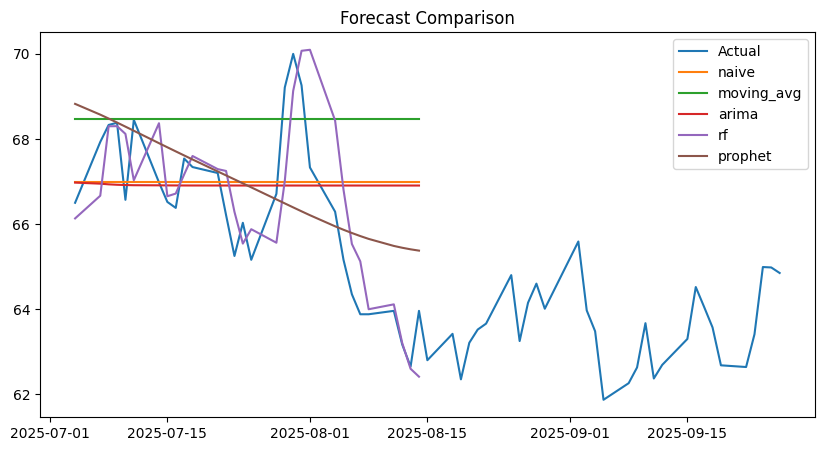

In [16]:
fig, ax = plt.subplots()
ax.plot(y_test.index, y_test, label="Actual")
for name, series in preds.items():
    ax.plot(series.index, series, label=name)
ax.set_title("Forecast Comparison")
ax.legend()
plt.show()


In [17]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

rows = []
for name, series in preds.items():
    if series is None:
        continue
    idx = y_test.index.intersection(series.index)
    if len(idx) == 0:
        continue
    rows.append({
        "Model": name,
        "RMSE": rmse(y_test.loc[idx], series.loc[idx]),
        "MAE":  mae(y_test.loc[idx], series.loc[idx])
    })

metrics_df = pd.DataFrame(rows).sort_values("RMSE").reset_index(drop=True)
metrics_df.style.format({"RMSE": "{:.3f}", "MAE": "{:.3f}"})


,Model,RMSE,MAE
0,rf,1.144,0.883
1,prophet,1.611,1.297
2,arima,1.951,1.558
3,naive,1.982,1.579
4,moving_avg,2.823,2.318


## 11. Save Artifacts

In [24]:
symbol_sanitized = SYMBOL.replace("=", "")
pred_export = pd.DataFrame(index=y_test.index)
pred_export["actual"] = y_test
for name, series in preds.items():
    if series is None:
        continue
    pred_export[name] = series.reindex(pred_export.index)

pred_path = ARTIFACTS / f"predictions_{symbol_sanitized}.csv"
# 👇 Reset index so the date is stored as column 'ds'
pred_export.reset_index().rename(columns={"index": "ds"}).to_csv(pred_path, index=False)
print("Saved:", pred_path)

Saved: artifacts/predictions_CLF.csv


## 12. Risk Analysis: Historical Simulation VaR

{'VaR_95': 0.037215145971885286, 'VaR_99': 0.0695965181744853}


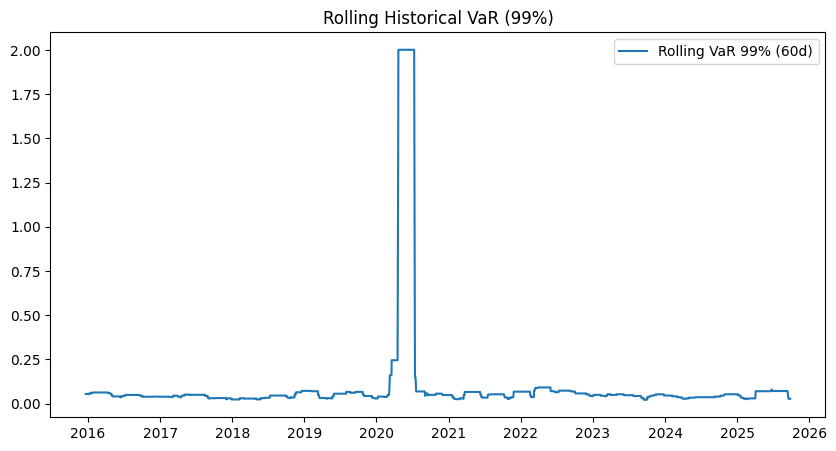

In [25]:
ALPHA_LIST = [0.95, 0.99]
rets = df["ret"].dropna()
losses = -rets

def hist_var(losses, alpha=0.95):
    return np.quantile(losses, alpha)

out = {}
for a in ALPHA_LIST:
    out[f"VaR_{int(a*100)}"] = float(hist_var(losses, a))

print(out)

roll_window = 60
roll_var = losses.rolling(roll_window).apply(lambda x: np.quantile(x.dropna(), 0.99))
fig, ax = plt.subplots()
ax.plot(roll_var.index, roll_var, label=f"Rolling VaR 99% ({roll_window}d)")
ax.set_title("Rolling Historical VaR (99%)")
ax.legend()
plt.show()

## 13. Business Insights (Template)

## Key Findings (based on my results)

- **Risk:** The 99% rolling VaR spiked dramatically in **Mar–Apr 2020**, capturing the unprecedented oil price crash during COVID. Outside of crisis periods, VaR stayed consistently low.  
- **Forecasting:**
  - **Naïve / Moving Average** → flat, good as benchmarks but uninformative in volatile regimes.  
  - **ARIMA** → reasonable in calm periods but under-reacted to sudden shocks.  
  - **Prophet** → imposed a smooth trend, useful for long-term direction but missed sharp moves.  
  - **Random Forest** → more responsive to short-term fluctuations, tracked volatility better than traditional models.  
- **Business link:** This mirrors how trading desks combine stable baselines with more adaptive ML approaches to manage forecasting accuracy and risk.

---

## What I’d Try Next

- Add exogenous drivers (U.S. crude inventories, crack spreads, USD index, OPEC+ events).  
- Apply volatility models (e.g. GARCH) or regime-switching to better capture crisis vs. stable regimes.  
- Run scenario analysis / stress testing for geopolitical or supply shocks to complement the VaR view.
